### Part 1: Generate Synthetic Networks (1 point)
Generate the following synthetic networks using the networkx package or another preferred library:
- Random networks (Erdos–Rényi) with:
  - n = 1000
  - Average degree (k) = 1 and 4
- Scale-free networks (Barabási–Albert) with:
  - n = 1000
  - m = 2 and 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import random

In [53]:
n = 1000
k_avg_list = [1, 4]
p_avg_list = [k / (n-1) for k in k_avg_list]
m_list = [2, 4]
er_graphs = [nx.erdos_renyi_graph(n, p) for p in p_avg_list]
ba_graphs = [nx.barabasi_albert_graph(n, m) for m in m_list]

### Part 2: Plot Degree Distributions (2 points)
Plot the degree distributions of the synthetic networks created in Part 1, as well as the degree distributions for networks provided in the datasets.

In [54]:
gml_files = [f for f in os.listdir("datasets/") if f.endswith(".gml")]

real_nws = [nx.read_gml(os.path.join("datasets/", path)) for path in gml_files]

In [55]:
graph_dict = {
    "ER_k=1": er_graphs[0],
    "ER_k=4": er_graphs[1],
    "BA_m=2": ba_graphs[0],
    "BA_m=4": ba_graphs[1],
    "Network_airlines": real_nws[0],
    "Network_power": real_nws[1]
}

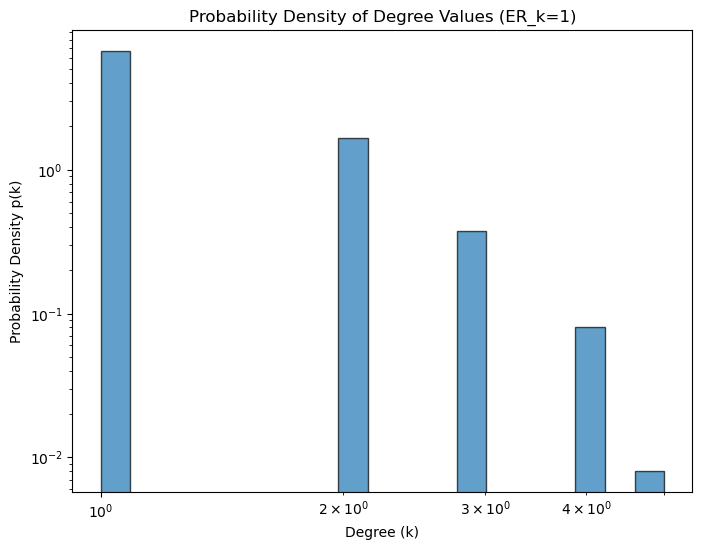

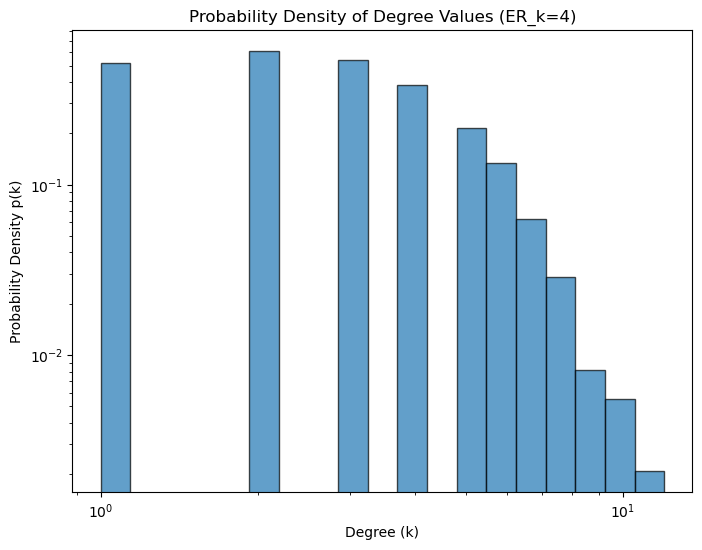

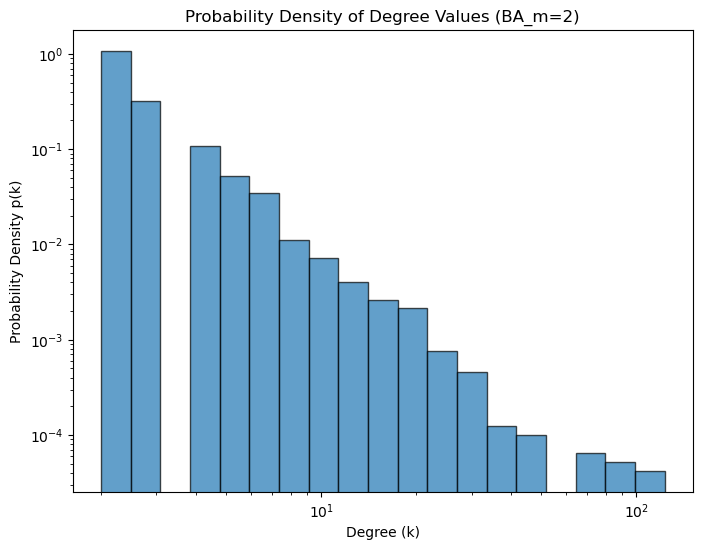

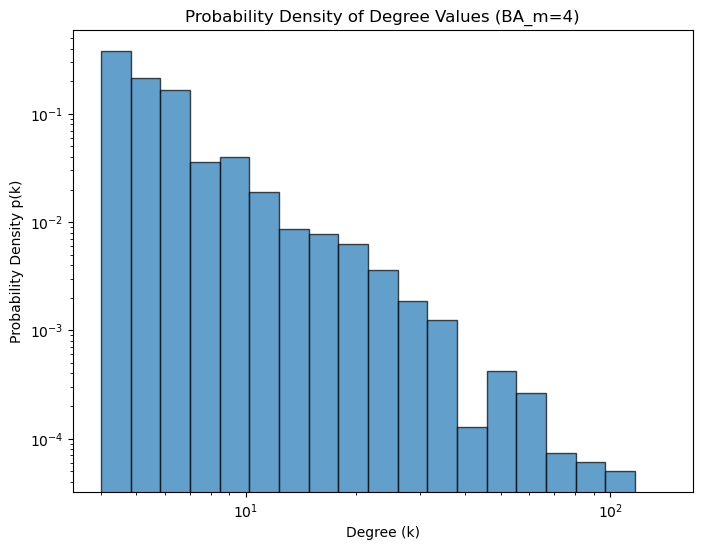

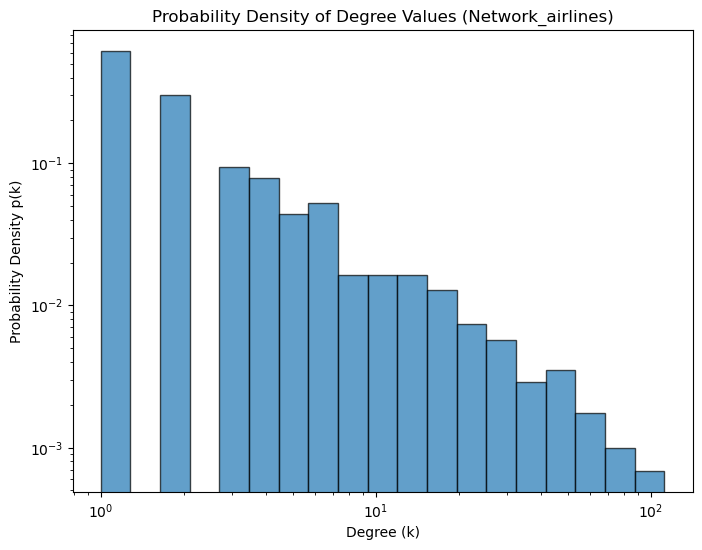

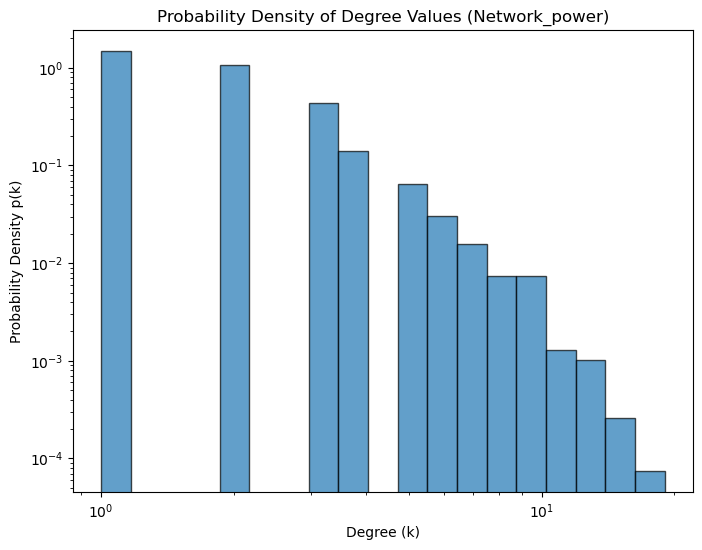

In [59]:
def plot_degree_distribution(g_dict):
    for label, graph in g_dict.items():
        degrees = [degree for node, degree in graph.degree()]
        degrees = [d for d in degrees if d > 0]

        min_degree = min(degrees)
        max_degree = max(degrees)

        bins = np.logspace(np.log10(min_degree), np.log10(max_degree), num=20)

        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=bins, density=True, edgecolor="black", alpha=0.7)

        plt.xscale("log")
        plt.yscale("log")

        plt.xlabel("Degree (k)")
        plt.ylabel("Probability Density p(k)")
        plt.title(f"Probability Density of Degree Values ({label})")
        plt.show()


plot_degree_distribution(graph_dict)

### Part 3: Largest Connected Component Size (2 points)
For both the synthetic graphs and the real networks, plot the size of the largest connected component as a function of removed edges and nodes in the following scenarios:
1. Random attacks (failures)
2. Targeted attacks (using degree centrality and betweenness centrality)

In [57]:
def get_giant_comp_size(graph):
    return len(max(nx.connected_components(graph), key=len))


def rnd_edge_attack(graph):
    start_comp_size = get_giant_comp_size(graph)
    graph_attack_timeline = [1]
    current_graph = graph.copy()
    while current_graph.number_of_edges() > 1:
        rnd_edge = random.choice(list(current_graph.edges()))
        current_graph.remove_edge(*rnd_edge)
        relative_comp_size = get_giant_comp_size(current_graph) / start_comp_size
        graph_attack_timeline.append(relative_comp_size)
    
    return graph_attack_timeline


def rnd_node_attack(graph):
    start_comp_size = get_giant_comp_size(graph)
    graph_attack_timeline = [1]
    current_graph = graph.copy()
    while current_graph.number_of_nodes() > 2:
        rnd_node = random.choice(list(current_graph.nodes()))
        current_graph.remove_node(rnd_node)
        relative_comp_size = get_giant_comp_size(current_graph) / start_comp_size
        graph_attack_timeline.append(relative_comp_size)
    
    return graph_attack_timeline


def targeted_degree_node_attack(graph):
    start_comp_size = get_giant_comp_size(graph)
    graph_attack_timeline = [1]
    current_graph = graph.copy()
    while current_graph.number_of_nodes() > 2:
        centrality = nx.degree_centrality(current_graph)
        attacked_node = max(centrality, key=centrality.get)
        current_graph.remove_node(attacked_node)
        relative_comp_size = get_giant_comp_size(current_graph) / start_comp_size
        graph_attack_timeline.append(relative_comp_size)
    
    return graph_attack_timeline
        
        
def targeted_betweenness_node_attack(graph):
    start_comp_size = get_giant_comp_size(graph)
    relative_comp_size = 1
    graph_attack_timeline = [relative_comp_size]
    current_graph = graph.copy()
    while current_graph.number_of_nodes() > 2:
        # takes far too long to compute: O(n^3), n can be up to 5000
        # centrality = nx.betweenness_centrality(current_graph)
        
        # alternative: O(n*c^2), c = subset_size
        nodes = list(current_graph.nodes())
        subset_size = min(10, len(nodes))  
        sources = random.sample(nodes, subset_size)
        targets = random.sample(nodes, subset_size)
        centrality = nx.betweenness_centrality_subset(current_graph, sources=sources, targets=targets)
        
        attacked_node = max(centrality, key=centrality.get)
        current_graph.remove_node(attacked_node)
        relative_comp_size = get_giant_comp_size(current_graph) / start_comp_size
        graph_attack_timeline.append(relative_comp_size)
    
    return graph_attack_timeline

2024-11-08 14:14:06.051801 - start:ER_k=1
0:00:09.481860 attack 1-3 duration
0:00:04.660510 betweenness duration


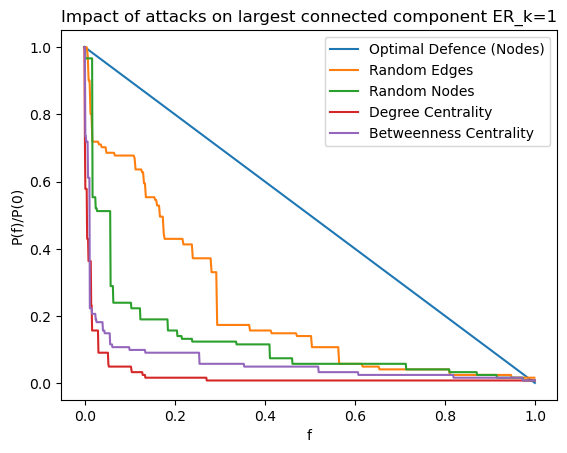

2024-11-08 14:14:20.452011 - start:ER_k=4
0:00:20.937458 attack 1-3 duration
0:00:17.199834 betweenness duration


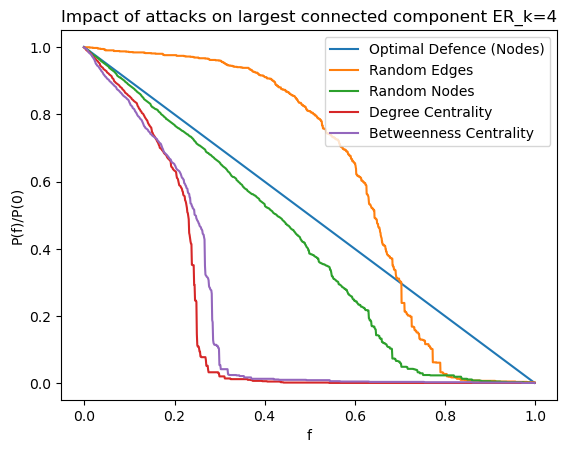

2024-11-08 14:14:58.882726 - start:BA_m=2
0:00:20.717449 attack 1-3 duration
0:00:08.654489 betweenness duration


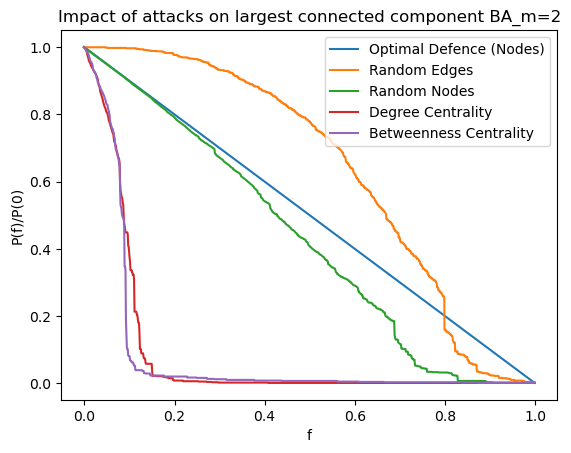

2024-11-08 14:15:28.543672 - start:BA_m=4
0:00:42.808320 attack 1-3 duration
0:00:22.278997 betweenness duration


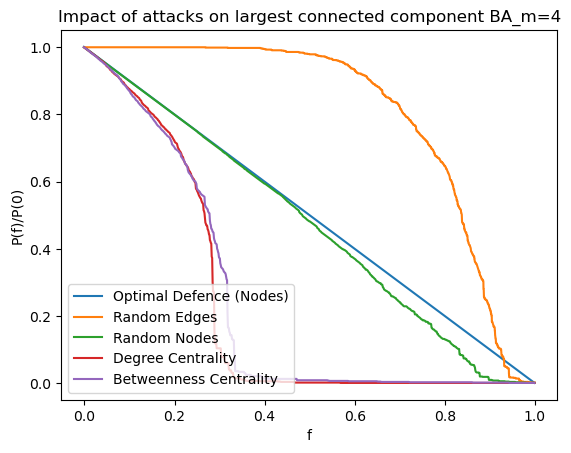

2024-11-08 14:16:33.959490 - start:Network_airlines
0:00:16.211592 attack 1-3 duration
0:00:02.379756 betweenness duration


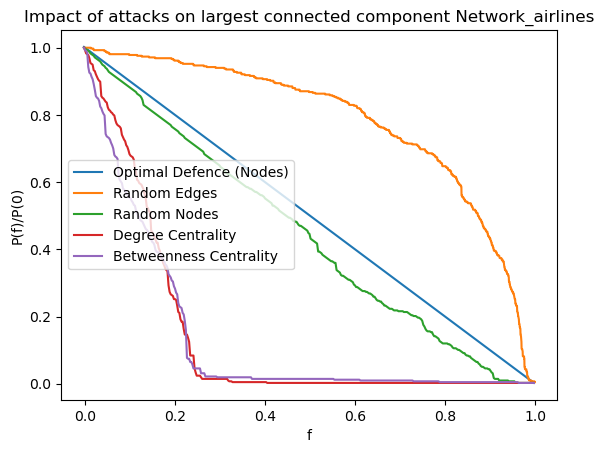

2024-11-08 14:16:52.851607 - start:Network_power
0:07:30.434957 attack 1-3 duration
0:03:25.054845 betweenness duration


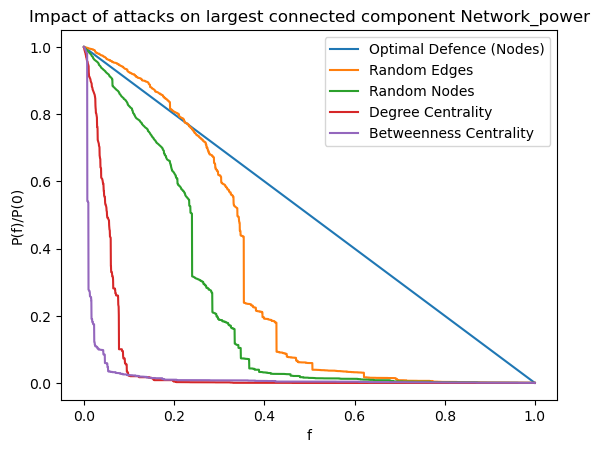

In [58]:
def plot_graph_attack(rnd_edge_time, rnd_node_time, degree_time, betweenness_time, title):
    edge_values = [(i-1)/(len(rnd_edge_time)-1) for i in range(len(rnd_edge_time))]
    node_values = [(i-1)/(len(rnd_node_time)-1) for i in range(len(rnd_node_time))]
    optimal_time = [1 - v for v in node_values]
    plt.plot(node_values, optimal_time, label="Optimal Defence (Nodes)")
    plt.plot(edge_values, rnd_edge_time, label="Random Edges")
    plt.plot(node_values, rnd_node_time, label="Random Nodes")
    plt.plot(node_values, degree_time, label="Degree Centrality")
    plt.plot(node_values, betweenness_time, label="Betweenness Centrality")
    plt.xlabel("f")
    plt.ylabel("P(f)/P(0)")
    plt.title(title)
    plt.legend()
    plt.show()
    

def plot_attacks(g_dict):
    for label, graph in g_dict.items():
        import datetime
        start_time = datetime.datetime.now()
        print(str(datetime.datetime.now()) + " - start: " + label)
        print("number of nodes: " + str(graph.number_of_nodes()))
        rnd_edge_time = rnd_edge_attack(graph)
        rnd_node_time = rnd_node_attack(graph)
        degree_time = targeted_degree_node_attack(graph)
        second_time = datetime.datetime.now() - start_time
        print(str(second_time) + " attack 1-3 duration")
        betweenness_time = targeted_betweenness_node_attack(graph)
        third_time = datetime.datetime.now() - start_time - second_time 
        print(str(third_time) + " betweenness duration")
        title = "Impact of attacks on largest connected component " + label 
        plot_graph_attack(rnd_edge_time, rnd_node_time, degree_time, betweenness_time, title)

plot_attacks(graph_dict)

### Part 4: Comments (1 point)
Provide commentary on the plots above, reflecting on the discussed concepts from the class sessions.


#### Attack comparison
* The **Random Edge attacks** have by far the least impact on relative component size per attack. That is because one node attack often removes more than one edge, also there tend to be far more edges than nodes.
* The **Random Node attacks** perform only slightly better than the theoretically Optimal Defence. The more edges per node, the more similar the two. Only in the case of ER_n=1 there is a strong difference. That is because the largest component is only very loosely connected with very little redundancy. In that case removing random nodes in there will often directly break the component apart.
* The **Degree Centrality based attacks** are far more effective than the "optimal defence". Within the first 0.1 to 0.3 first nodes the largest connected component reduce to about 5% of the original. (Also degree centrality is fairly easy to calculate and therefore fast)

##### Betweenness Attacks
* We adapted **Betweenness Centrality Attack** calculation, since by default it has a complexity of O(n^3) per attack and n attacks (with linearly decreasing n). The second provided network contains almost 5000 nodes. That would take far too long to compute.
* Instead of calculating the smallest distance between all node pairs and calculating respective betweenness ratings - we selected a small subset of nodes. Only for this subset the shortest distance gets calculated and based on this path subset, the betweenness value gets calculated for all the nodes. This subset based calculation is then used to select the next node to attack. The respective betweenness calculations only have a complexity of O(n * c^2), with c being the subset size. This makes it possible to calculate the betweenness sufficiently quickly.
* This faster calculation, based on random samples is less efficient than its original approach. The original approach tends to outperform degree centrality attacks more clearly (Based on experience from previous tries). Also, the small sample could make it more difficult to find relevant nodes in the case of many small components, due to the difficulty of finding any paths connecting random node pairs.

#### Graph Type comparison
* Note that in ER graphs, *k* indicates the average degree per node, whereas in BA graphs *m* stands for edges added per new node. As each edge has two nodes attached to it, so for BA graphs the following holds true: 
 * average degree = 2*m
* So the only comparison, which compares two graphs with the same amount of nodes, as well as same average degree is comparing ER_k=4 to BA_m=2.
* In this direct comparison it can be seen, that BA_m=2 defends slightly better against Random Edge Attacks and against Random Node Attacks, as we have seen in the lecture.
* In contrast, the targeted attacks almost completely destroyed BA_m=2 with only 0.1 of node removal - whereas for ER_k=4 almost 0.3 node removal was needed. This weakness of scale free networks towards targeted attacks was also discussed in the lecture.
##### Real Network Analysis 
* It is not easy to make conclusions about the provided networks, since the interpretation would depend on average degree and number of nodes, not solely on the plots alone. 
* Still we can assume that average degree in **Network_power** is not that high, since even in random attacks the largest components shrinks and diminishes quickly, indicating limited redundancy. 
 * This conclusion is in line with the degree distribution, which shows in this network most nodes have a degree of 1 and likelihood for higher degrees decrease strongly.
* **Network_airlines** is somewhat robust to attacks, similar to ER_k=4 or BA_m=4, indicating that it is either not scale-free, or has quite high average node degree.
 * The degree probability shows, that it is quite similar to BA_m=4, and indicates a high average node degree and power law distribution.